**animation_gt_zoom_in.ipynb**

**Function**: Create animation for ground truth of test dataset (zoom in specific locations of the final results)

**Purpose**: Find which parts contain more changes (for qualitative comparison)

In [1]:
# input images path
# Diff between sn7 and sn7_winner_split (gt for test dataset saves at sn7/)
# src_img_root = '/Midgard/Data/hfang/sn7/test_public'
src_img_root = '/Midgard/Data/hfang/sn7/train'

In [2]:
# import necessary packages
import os
import re
import time
import random
import sys
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
import cv2
import skimage.io
from skimage.draw import polygon
from skimage import measure
from skimage.segmentation import watershed
# from skimage.feature import peak_local_max

# import bug-free peak_local_max
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from peak import peak_local_max

from scipy import ndimage as ndi
from rasterio import features

import solaris as sol
from shapely.ops import cascaded_union
from shapely.geometry import shape, Polygon

In [3]:
# Get the list of npy_files and AOIs

# no matter what the pred_root is (alpha: .5/.9/1)
pred_root = '/Midgard/home/hfang/temporal_CD/Berzelius_HRNet_SN7/berzelius_seg_hrnet_tcr_w48_512x512_sgd_lr1e-3_wd1e-4_bs_64_epoch70_alpha_1_train/npy_compose'

# dictionary: key -> AOI, value -> npy_files
dic = {}
npy_files = [os.path.join(pred_root, x) for x in os.listdir(pred_root)]
for npy_file in npy_files:
    key = '_'.join(npy_file.split('/')[-1].split('.')[0].split('_')[5:])
    if key not in dic:
        dic[key] = [npy_file]
    else:
        dic[key].append(npy_file)
        
params = []
aois = []
for aoi, npy_list in dic.items():
    print("Process:", aoi)
    aois.append(aoi)
    params.append(npy_list)
    
print(aois)

Process: L15-0566E-1185N_2265_3451_13
Process: L15-1276E-1107N_5105_3761_13
Process: L15-1015E-1062N_4061_3941_13
Process: L15-0632E-0892N_2528_4620_13
Process: L15-1615E-1206N_6460_3366_13
Process: L15-1438E-1134N_5753_3655_13
Process: L15-1848E-0793N_7394_5018_13
Process: L15-0387E-1276N_1549_3087_13
Process: L15-1200E-0847N_4802_4803_13
Process: L15-1690E-1211N_6763_3346_13
['L15-0566E-1185N_2265_3451_13', 'L15-1276E-1107N_5105_3761_13', 'L15-1015E-1062N_4061_3941_13', 'L15-0632E-0892N_2528_4620_13', 'L15-1615E-1206N_6460_3366_13', 'L15-1438E-1134N_5753_3655_13', 'L15-1848E-0793N_7394_5018_13', 'L15-0387E-1276N_1549_3087_13', 'L15-1200E-0847N_4802_4803_13', 'L15-1690E-1211N_6763_3346_13']


In [4]:
# Get the reponding input images and ground truth images
def get_respond_img(npy_file):
    sp = npy_file.split('.')[0].split('_')
    aoi = '_'.join(sp[5:])
    src_img_path = os.path.join(src_img_root, aoi, "images_masked", npy_file.replace(".npy", ".tif"))
    return src_img_path

def get_respond_gt(npy_file):
    sp = npy_file.split('.')[0].split('_')
    aoi = '_'.join(sp[5:])
    gt_img_path = os.path.join(src_img_root, aoi, "masks", npy_file.replace(".npy", "_Buildings.tif"))
    return gt_img_path

In [5]:
# import necessary packages for visualization
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams.update({'font.size': 16})
mpl.rcParams['figure.dpi'] = 300
from matplotlib import animation

# HTML 
from IPython.display import HTML

In [6]:
# create lists of input images, ground truth images
def generate_list(npy_list):
    npy_list = sorted(npy_list)
    src_imgs = []
    gt_imgs = []

    for iii, npy_file in enumerate(npy_list):
        img_file = get_respond_img(npy_file.split('/')[-1])
        src_img = skimage.io.imread(img_file)
        src_imgs.append(src_img)

        gt_file = get_respond_gt(npy_file.split('/')[-1])
        gt_img = skimage.io.imread(gt_file)
        gt_imgs.append(gt_img)
        
    return src_imgs, gt_imgs

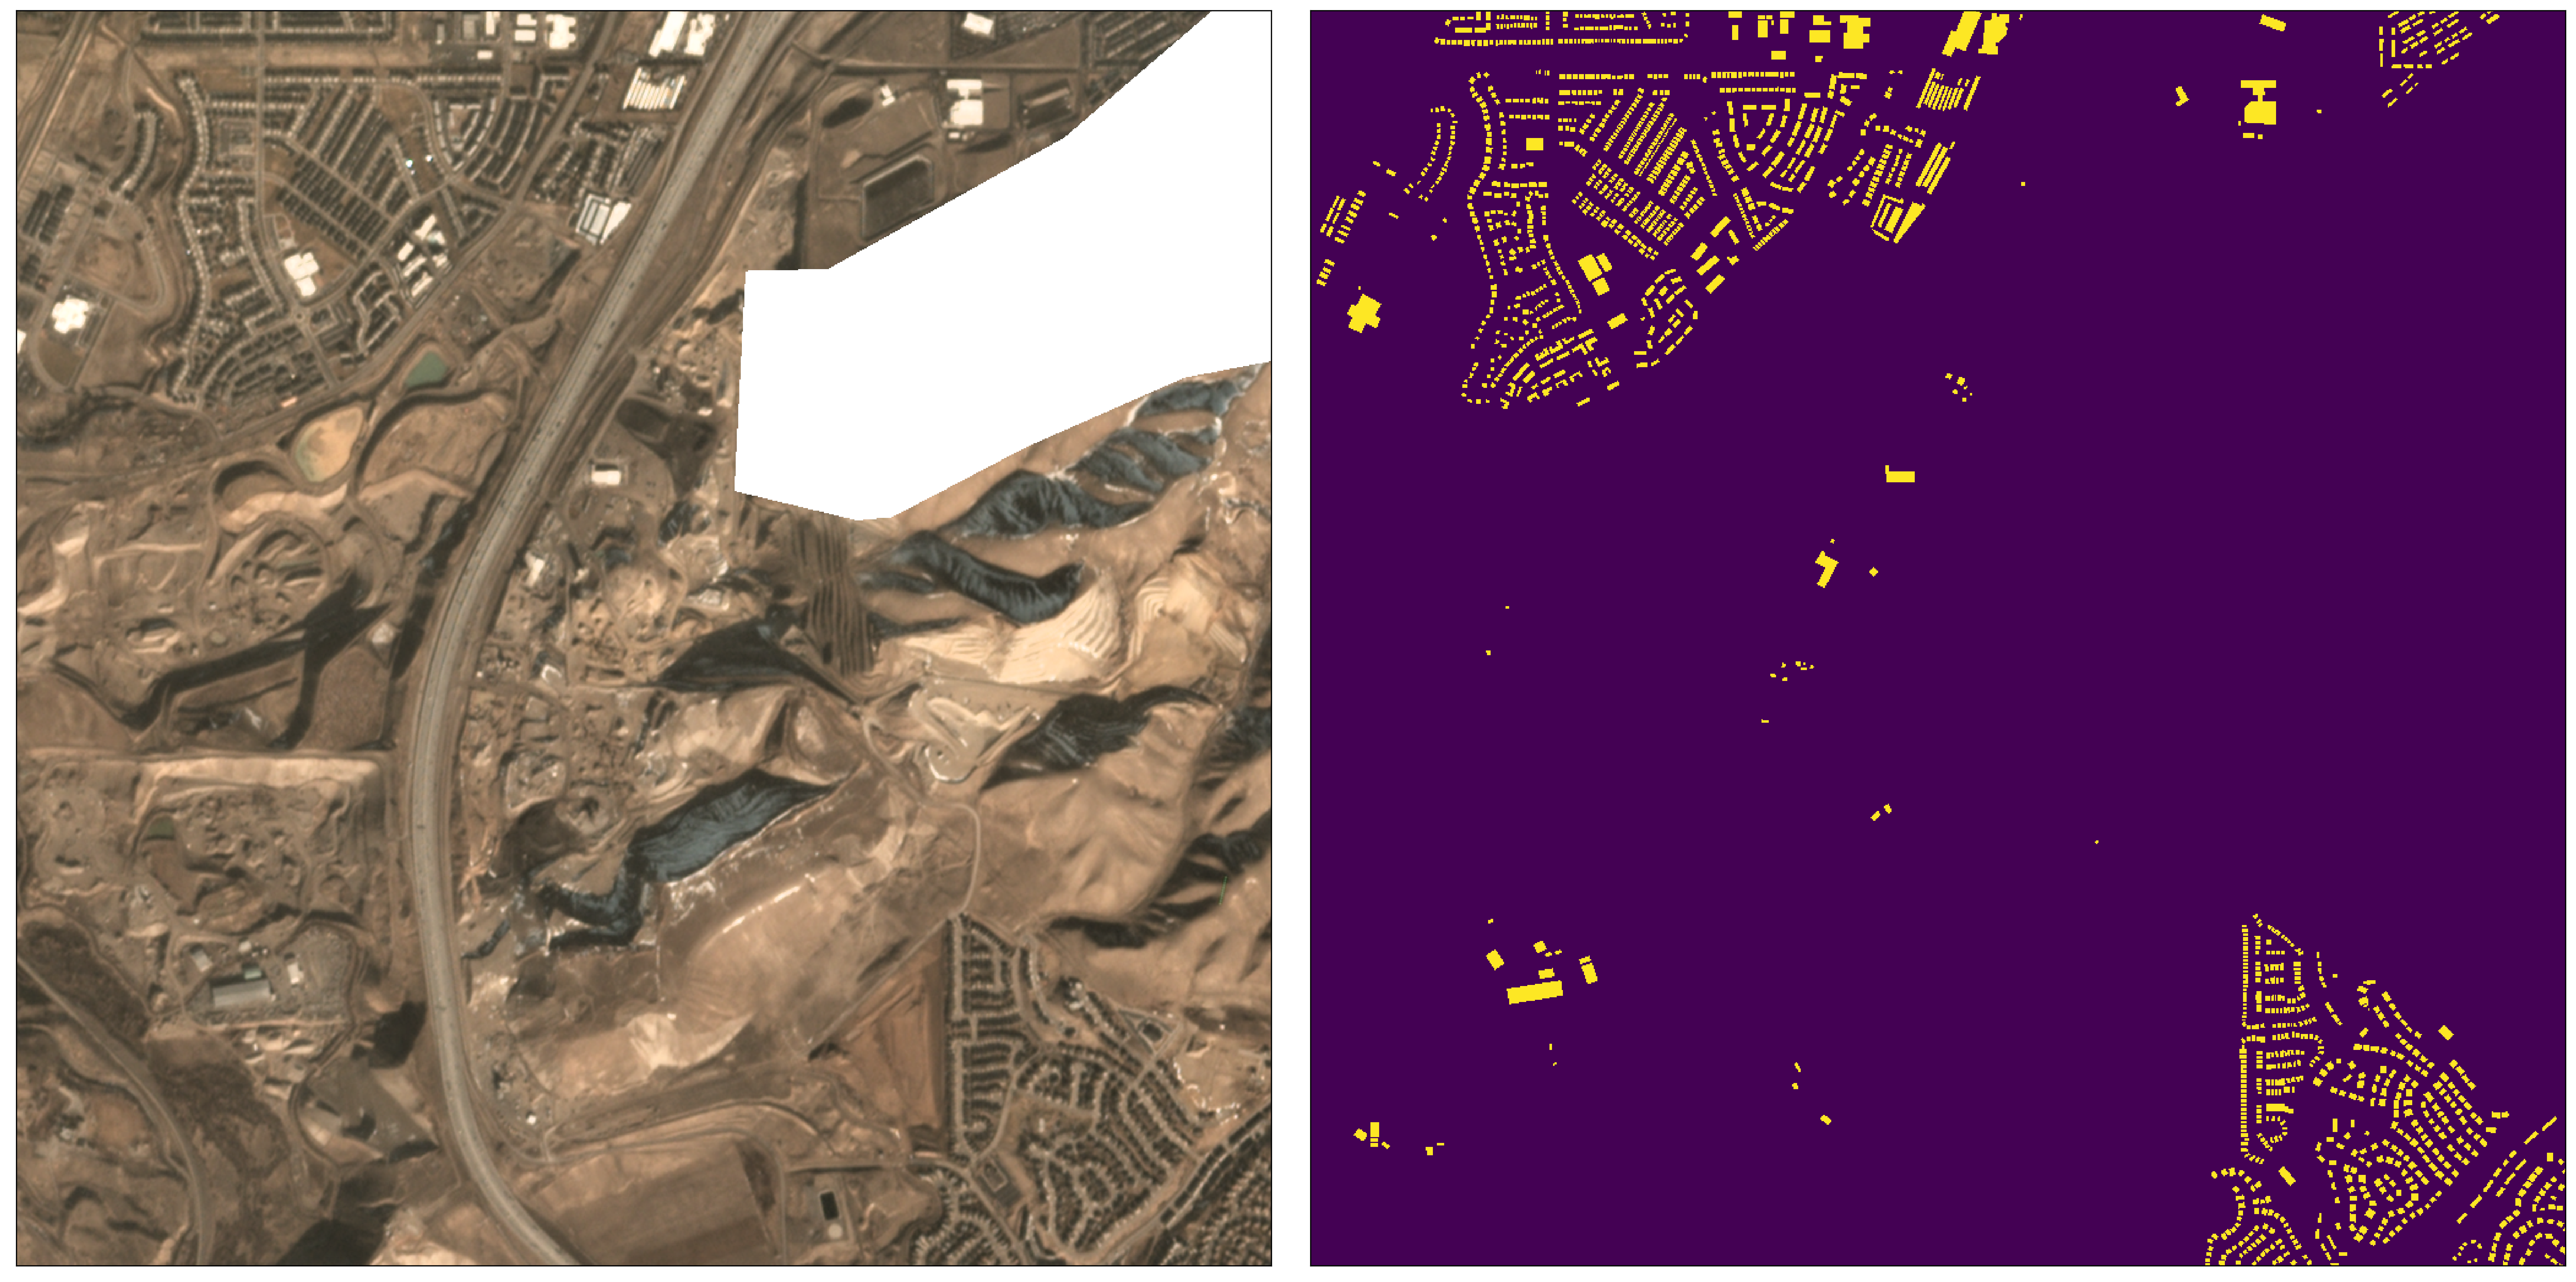

In [7]:
# Analyze one by one
npy_list = dic['L15-0387E-1276N_1549_3087_13']
src_imgs, gt_imgs = generate_list(npy_list)

figsize=(24, 12)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(src_imgs[-1])
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(gt_imgs[-1])
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()

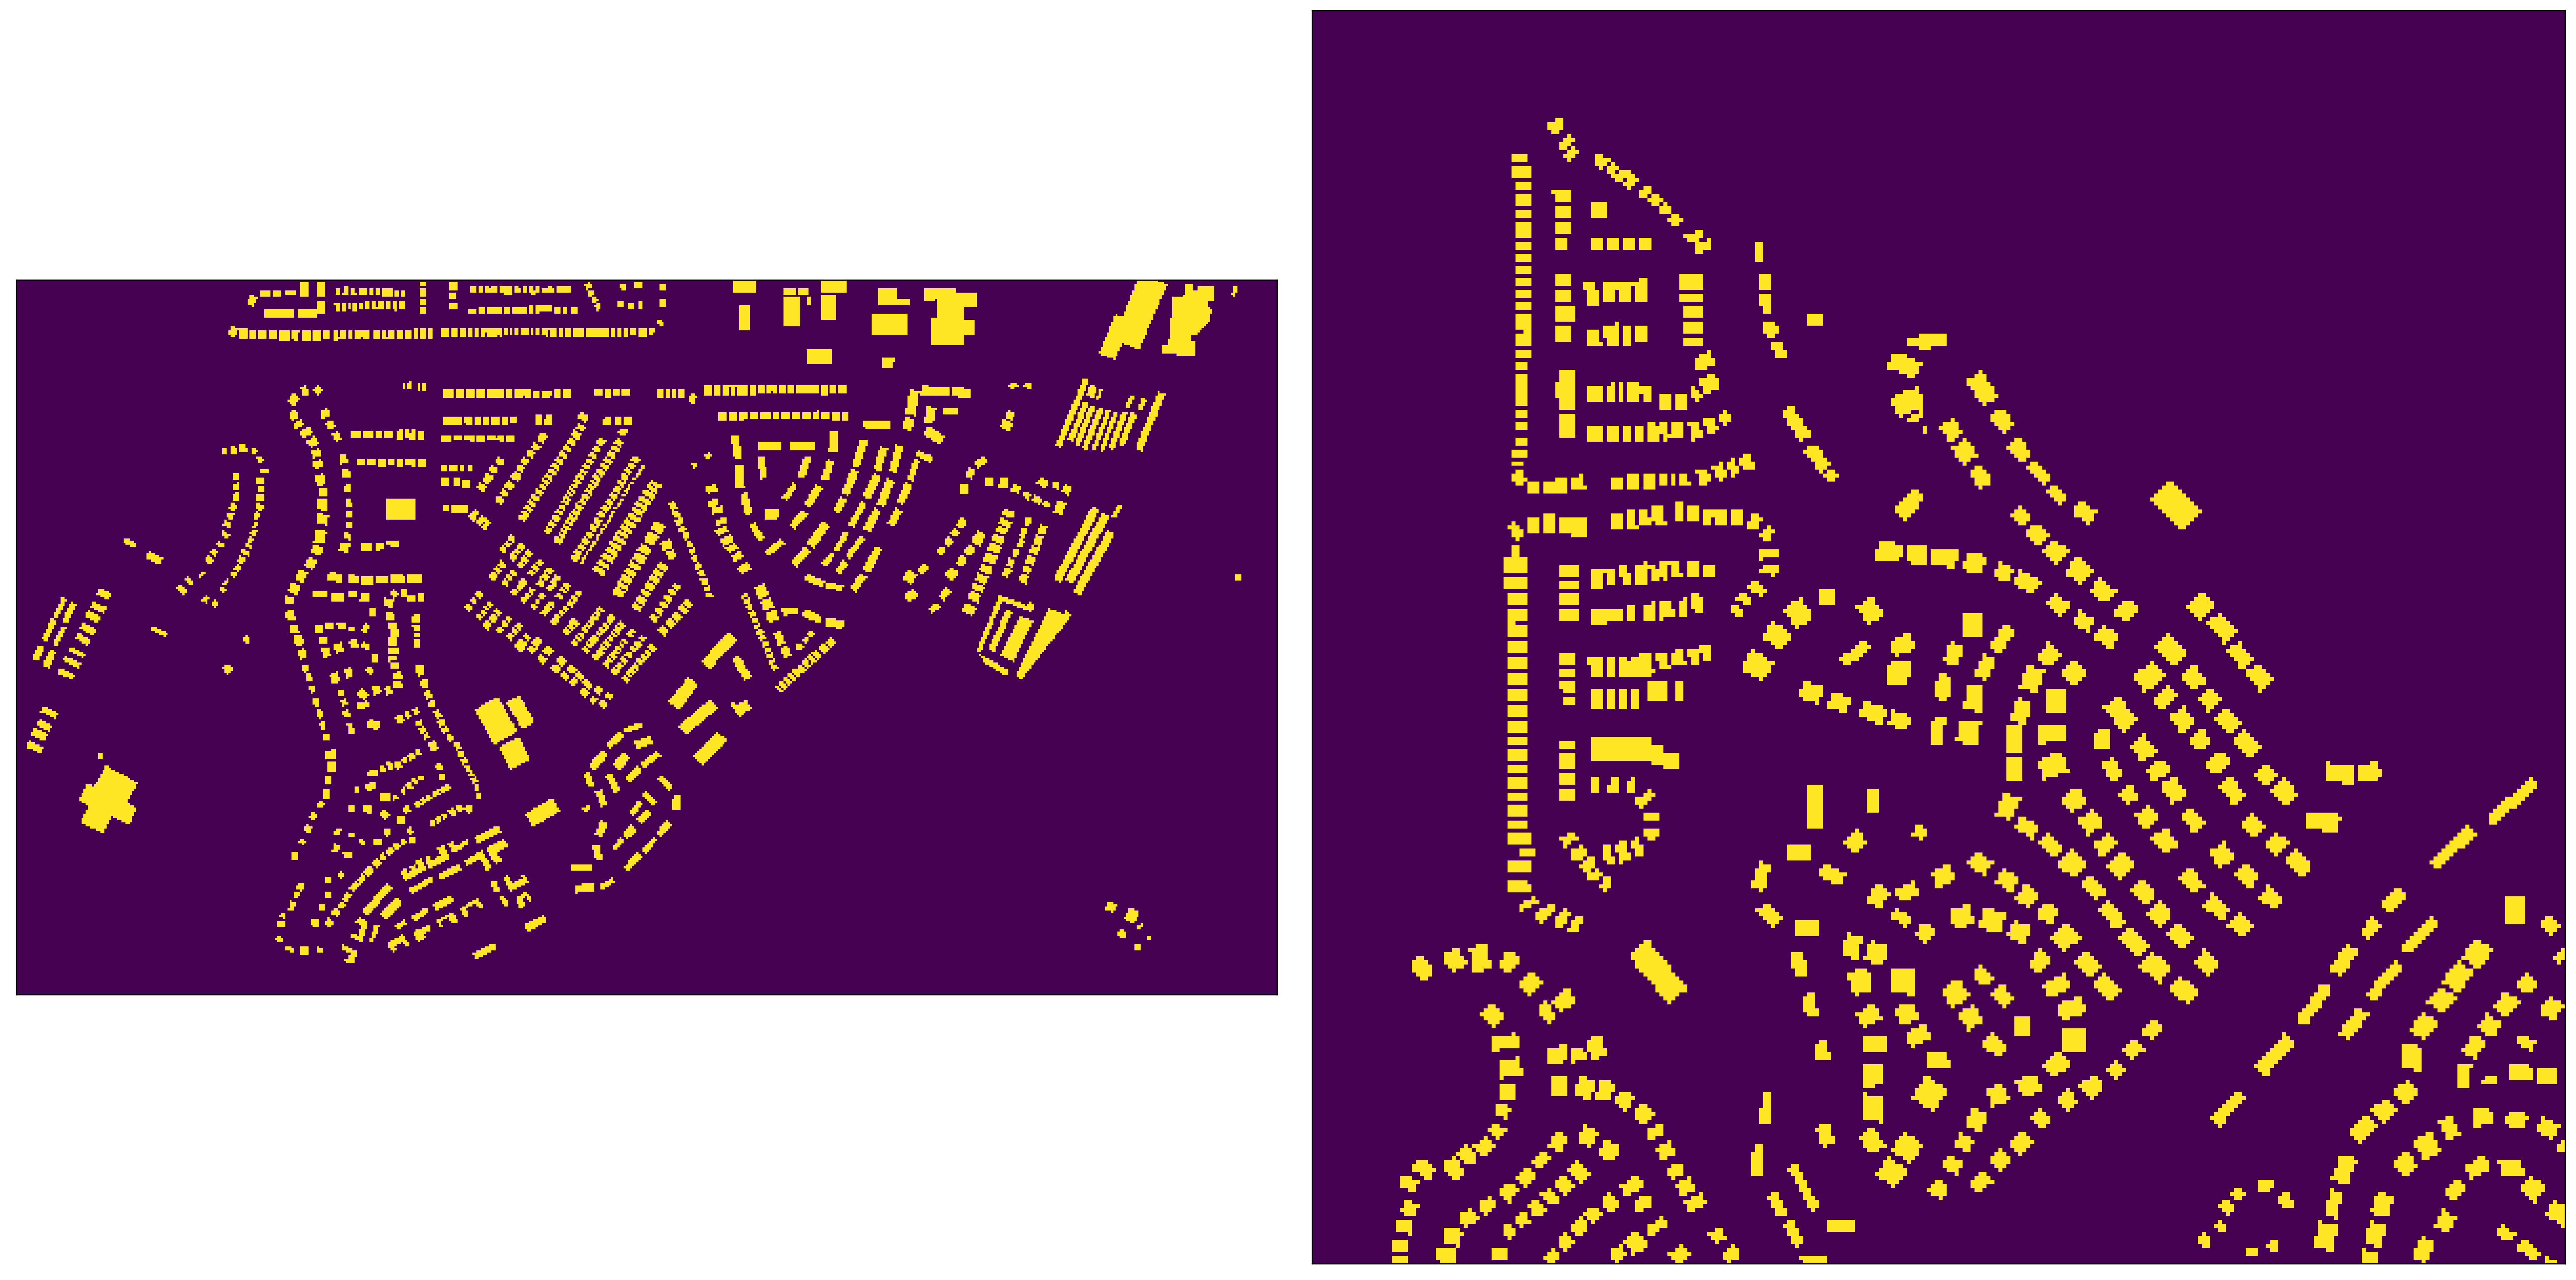

In [8]:
figsize=(24, 12)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(gt_imgs[-1][0:340, 0:600])
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(gt_imgs[-1][710:1024, 710:1024])
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()

In [7]:
# create animation for ground truth of test dataset
def create_animation(src_imgs, gt_imgs, x0, x1, y0, y1):
    """
    Create a Matplotlib animation of the given images.
    """
    plt.ioff()
    figsize=(24, 12)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    plt.ion()
    
    def animation_func(i):
        _ = ax0.imshow(src_imgs[i][x0:x1, y0:y1])
        ax0.set_xticks([])
        ax0.set_yticks([])
        _ = ax1.imshow(gt_imgs[i][x0:x1, y0:y1])
        ax1.set_xticks([])
        ax1.set_yticks([])
        
    anim = animation.FuncAnimation(fig, animation_func, frames=len(src_imgs), interval=1000)
    
    plt.close(fig)
    return anim

In [10]:
anim = create_animation(src_imgs[::1], gt_imgs[::1], 0, 340, 0, 600)
%time anim.save('animation_gt/L15-0387E-1276N_1549_3087_13_0_340_0_600.gif', writer='pillow')

CPU times: user 2min 16s, sys: 25.6 s, total: 2min 42s
Wall time: 2min 45s


In [11]:
anim = create_animation(src_imgs[::1], gt_imgs[::1], 710, 1024, 710, 1024)
%time anim.save('animation_gt/L15-0387E-1276N_1549_3087_13_710_1024_710_1024.gif', writer='pillow')

CPU times: user 3min 58s, sys: 24.8 s, total: 4min 23s
Wall time: 4min 28s


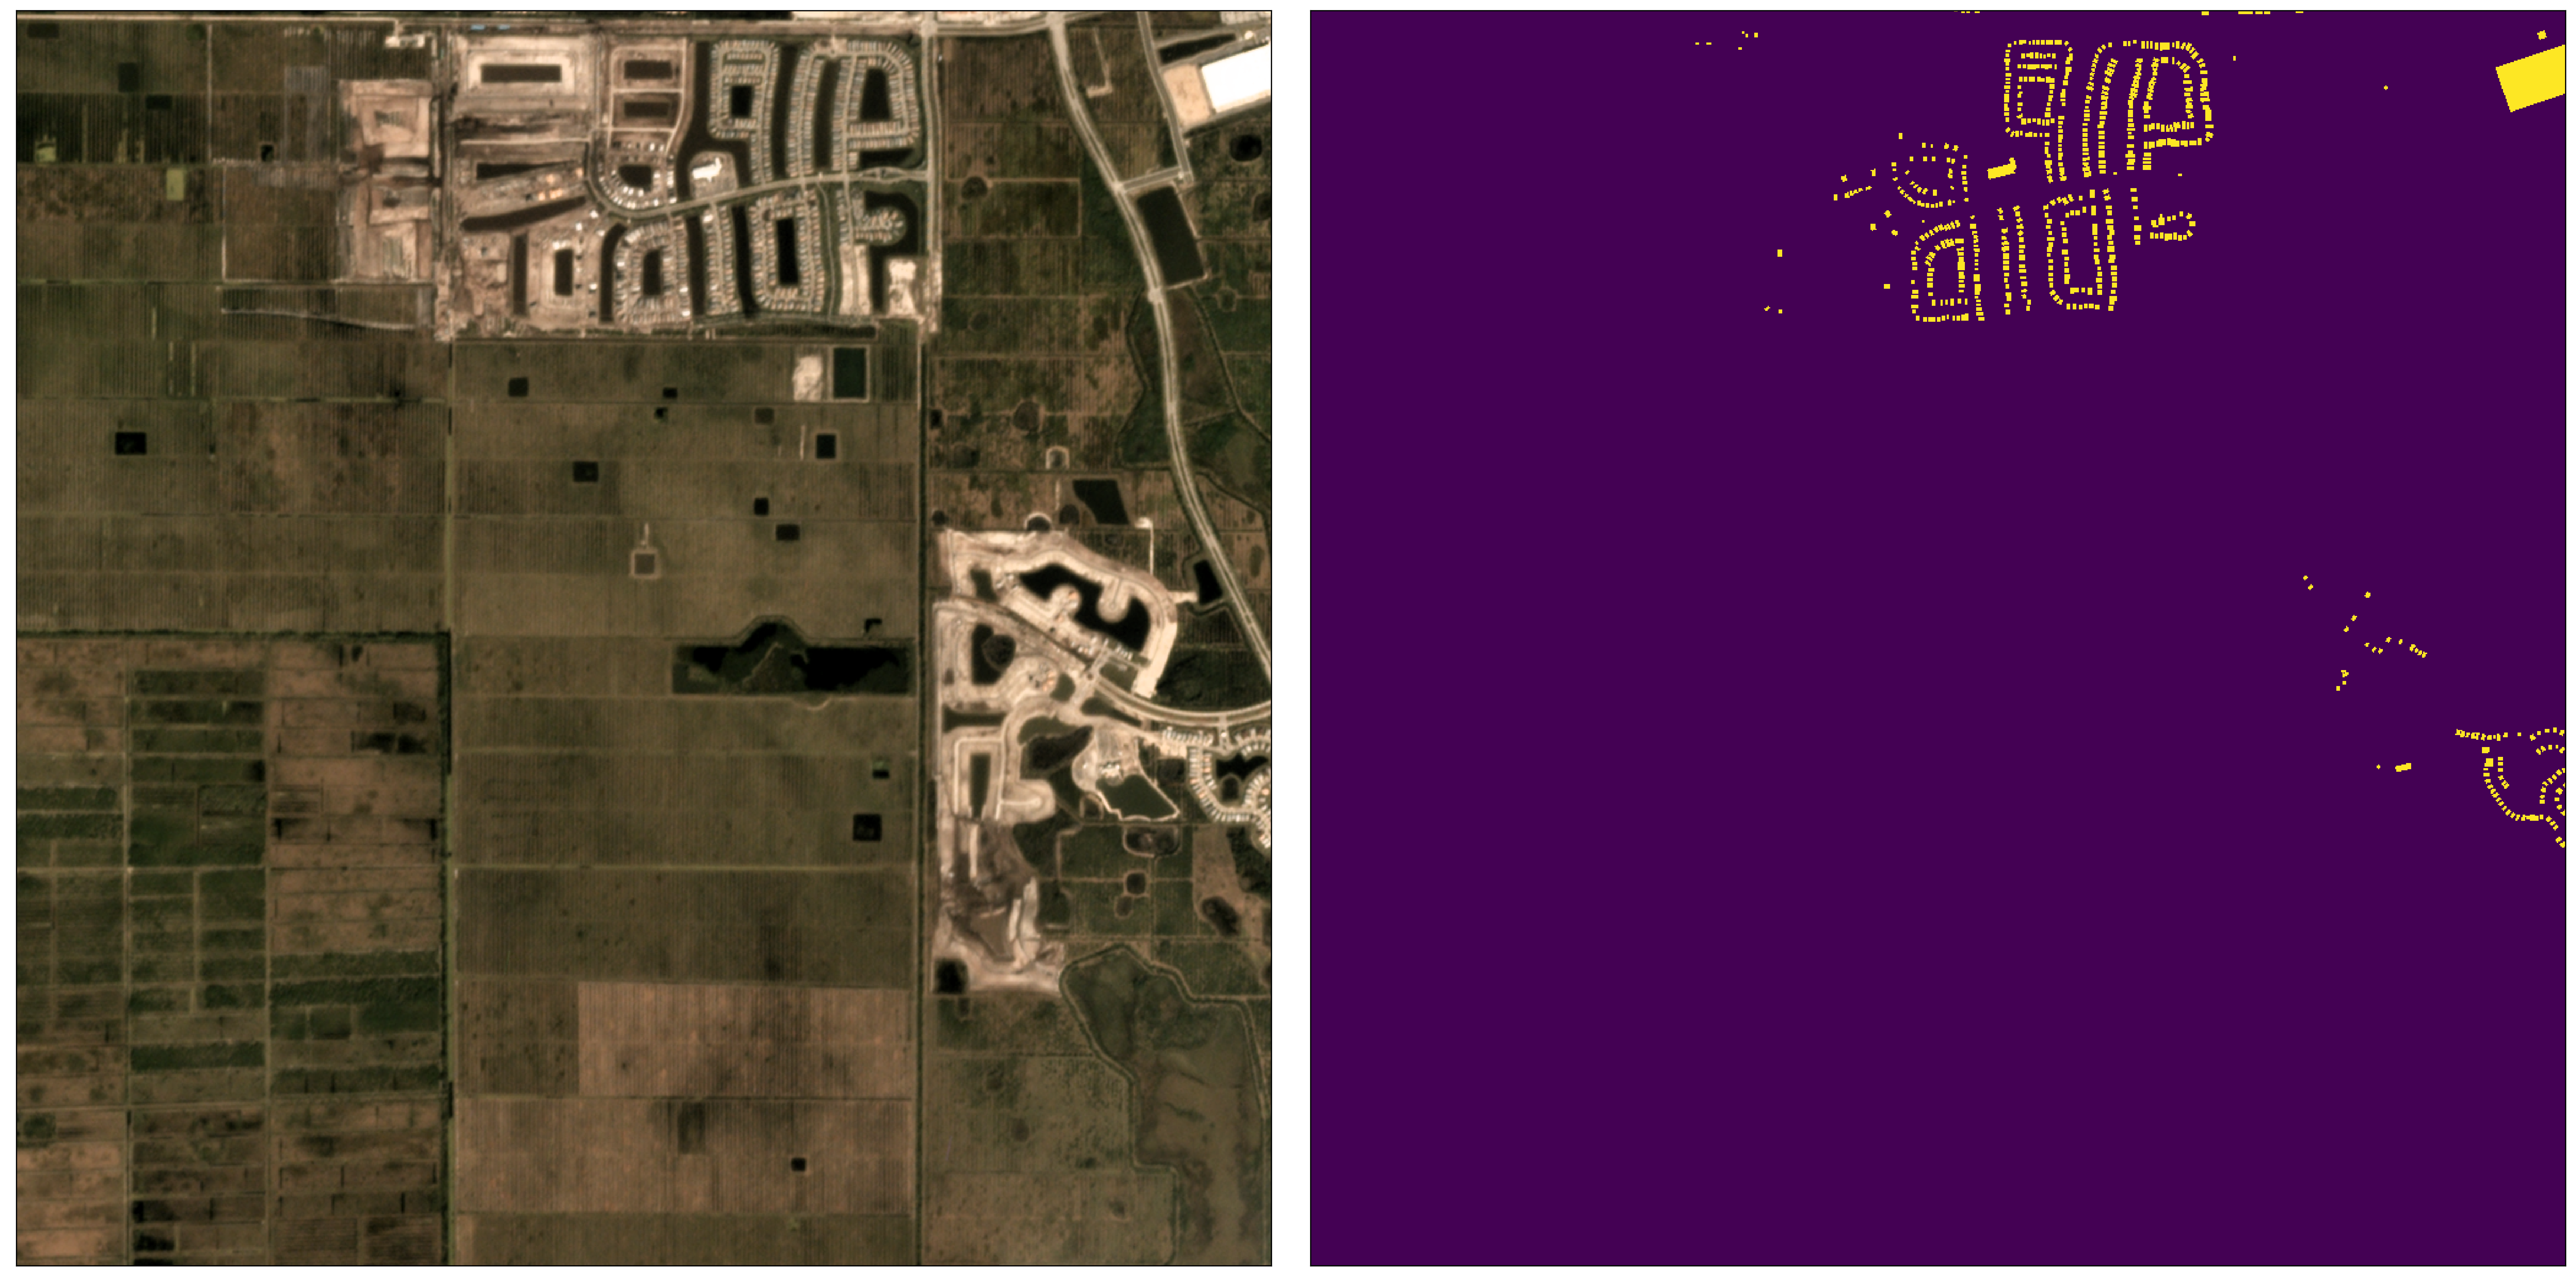

In [8]:
# Analyze one by one
npy_list = dic['L15-0566E-1185N_2265_3451_13']
src_imgs, gt_imgs = generate_list(npy_list)

figsize=(24, 12)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(src_imgs[-1])
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(gt_imgs[-1])
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()

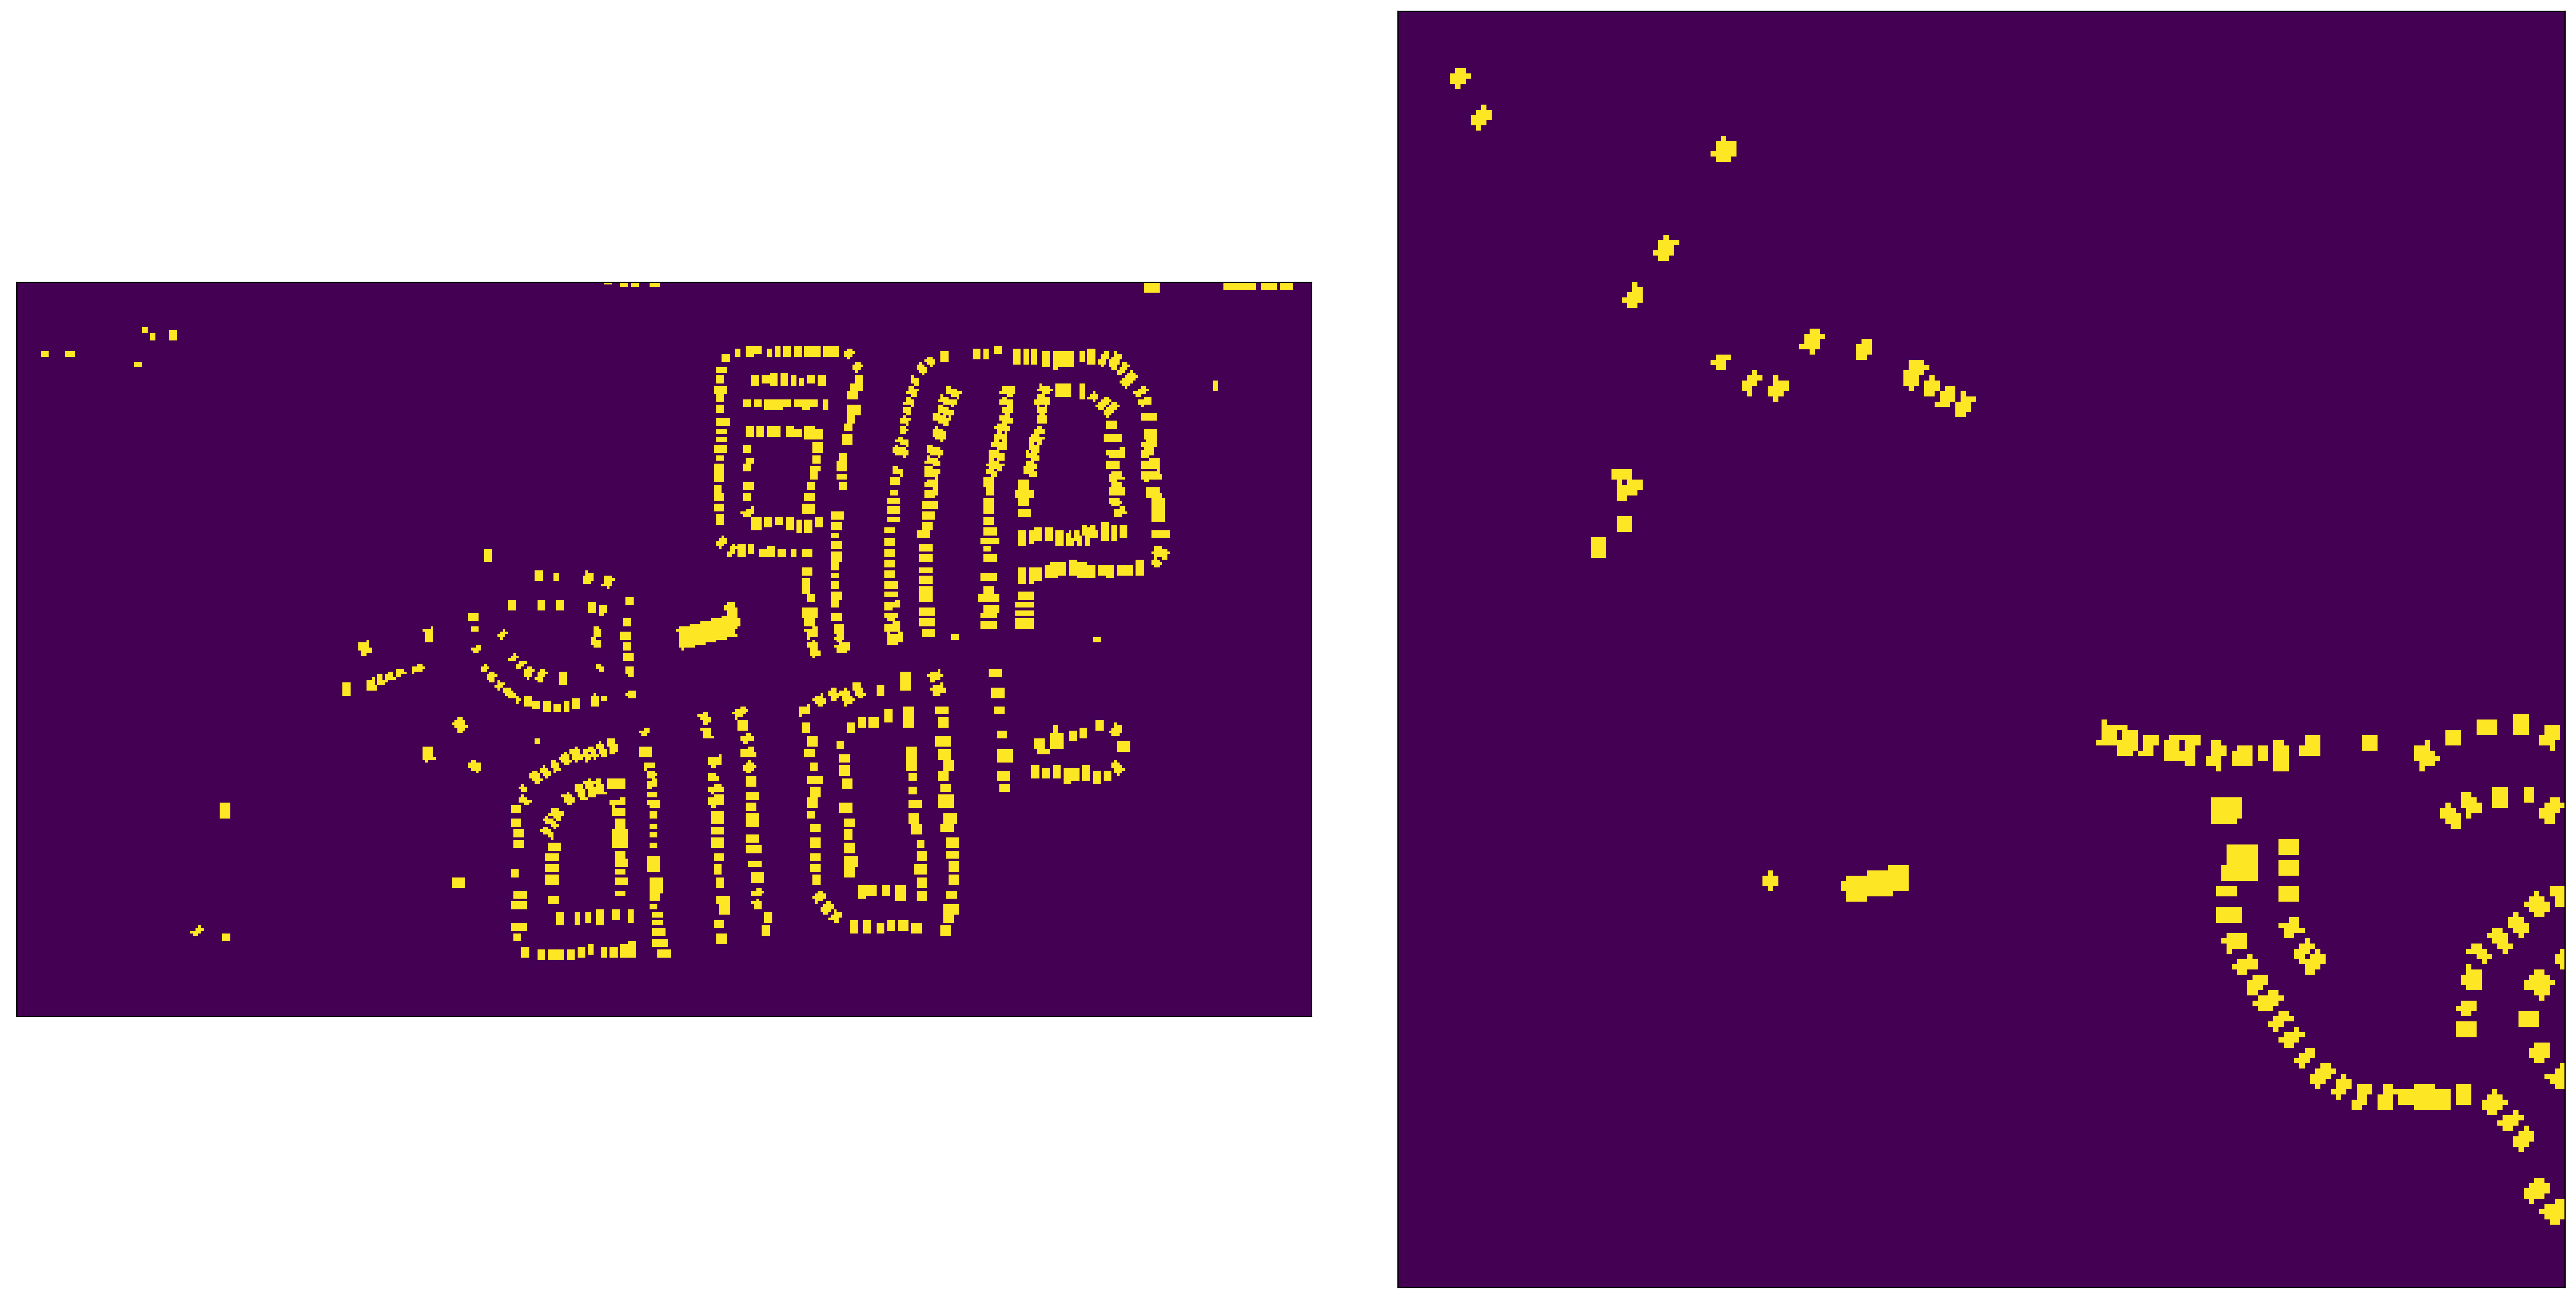

In [9]:
figsize=(24, 12)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
_ = ax0.imshow(gt_imgs[-1][0:275, 305:790])
ax0.set_xticks([])
ax0.set_yticks([])
_ = ax1.imshow(gt_imgs[-1][450:695, 800:1024])
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()

In [ ]:
anim = create_animation(src_imgs[::1], gt_imgs[::1], 0, 275, 305, 790)
%time anim.save('animation_gt/L15-0566E-1185N_2265_3451_13_0_275_305_790.gif', writer='pillow')

In [ ]:
anim = create_animation(src_imgs[::1], gt_imgs[::1], 450, 695, 800, 1024)
%time anim.save('animation_gt/L15-0566E-1185N_2265_3451_13_450_695_800_1024.gif', writer='pillow')

In [ ]:
# Full loop to create animation of all test dataset

for aoi in aois:
    npy_list = dic[aoi]
    print(aoi)
    
    # Get the location of the corresponding original images
    if not os.path.exists(os.path.join(src_img_root, aoi, "images_masked")):
        src_img_root = '/Midgard/Data/hfang/sn7/test_public'
    else:
        src_img_root = '/Midgard/Data/hfang/sn7/train'
    print(src_img_root)
    
    src_imgs, gt_imgs = generate_list(npy_list)
    anim = create_animation(src_imgs[::1], gt_imgs[::1])
    %time anim.save('animation_gt/' + aoi + '_gt.gif', writer='pillow')

In [ ]:
# Full loop to create animation of all test dataset

aoi_done = ['L15-0566E-1185N_2265_3451_13', 'L15-1276E-1107N_5105_3761_13', 'L15-1015E-1062N_4061_3941_13', 'L15-0632E-0892N_2528_4620_13']
aoi_special = ['L15-1615E-1206N_6460_3366_13', 'L15-1200E-0847N_4802_4803_13']

for aoi in aois:
    if aoi in aoi_done or aoi in aoi_special:
        continue
    npy_list = dic[aoi]
    print(aoi)
    
    # Get the location of the corresponding original images
    if not os.path.exists(os.path.join(src_img_root, aoi, "images_masked")):
        src_img_root = '/Midgard/Data/hfang/sn7/test_public'
    else:
        src_img_root = '/Midgard/Data/hfang/sn7/train'
    print(src_img_root)
    
    src_imgs, gt_imgs = generate_list(npy_list)
    anim = create_animation(src_imgs[::1], gt_imgs[::1])
    %time anim.save('animation_gt/' + aoi + '_gt.gif', writer='pillow')

In [ ]:
# Get the reponding ground truth images (/Midgard/Data is read-only now)
def get_respond_gt(npy_file):
    sp = npy_file.split('.')[0].split('_')
    aoi = '_'.join(sp[5:])
    gt_img_path = os.path.join('/Midgard/home/hfang/sn7_test_public_gt/test_public/', aoi, "masks", npy_file.replace(".npy", "_Buildings.tif"))
    return gt_img_path

for aoi in aoi_special:
    npy_list = dic[aoi]
    print(aoi)
    
    src_img_root = '/Midgard/Data/hfang/sn7/test_public'
    
    src_imgs, gt_imgs = generate_list(npy_list)
    anim = create_animation(src_imgs[::1], gt_imgs[::1])
    %time anim.save('animation_gt/' + aoi + '_gt.gif', writer='pillow')